In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
df = pd.read_csv('creditcard.csv')
print(df.shape)

(284807, 31)


Time variable
284802    47.996111
284803    47.996389
284804    47.996667
284805    47.996667
284806    47.997778
Name: Time_Hr, dtype: float64


Text(0, 0.5, '# transactions')

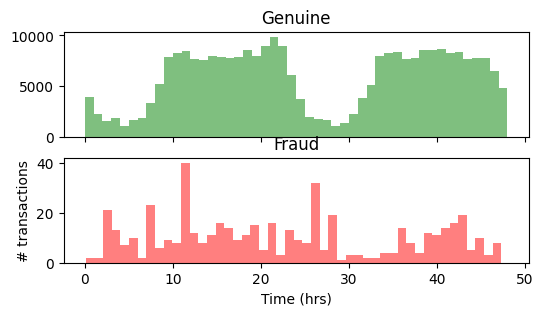

In [ ]:
print("Time variable")
df["Time_Hr"] = df["Time"]/3600 # convert to hours
print(df["Time_Hr"].tail(5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(6,3))
ax1.hist(df.Time_Hr[df.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(df.Time_Hr[df.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('# transactions')
# The 'Time' feature was converted into hourly units as 'Time_Hr' for visual analysis,
# and since both genuine and fraudulent transactions show a similar pattern—more frequent during daytime and less frequent at night
# 'Time_Hr' alone may not offer strong discriminative power for classification, so for clarity and simplicity, we retain 'Time_Hr' while dropping the original 'Time' column.

In [ ]:
df = df.drop(['Time'],axis=1)

Text(0, 0.5, '# transactions')

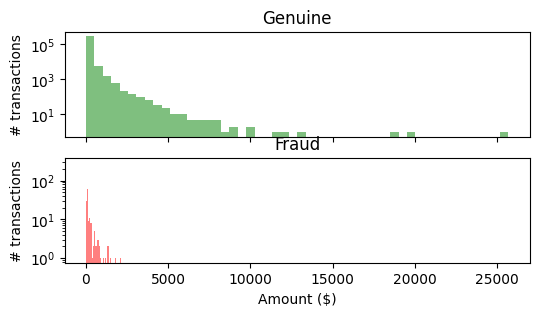

In [ ]:
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (6,3), sharex = True)
ax3.hist(df.Amount[df.Class==0],bins=50,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Genuine') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(df.Amount[df.Class==1],bins=50,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('# transactions')
#Since fraudulent transactions rarely occur when the transaction amount is around $10,000 or higher,
#we will later compare the model's performance with and without the Amount feature.

In [ ]:
from sklearn.preprocessing import StandardScaler
df['scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'],axis=1)
# The 'Amount' feature is on a different scale compared to the other principal components(V1~V28),
# so it will be standardized using StandardScaler and stored in the dataframe for later use.

<ipython-input-75-fb6c95302d01>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col][df.Class == 1], bins=50, color='r')
<ipython-input-75-fb6c95302d01>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col][df.Class == 0], bins=50, color='g')
<ipython-input-75-fb6c95302d01>:7: UserWarning

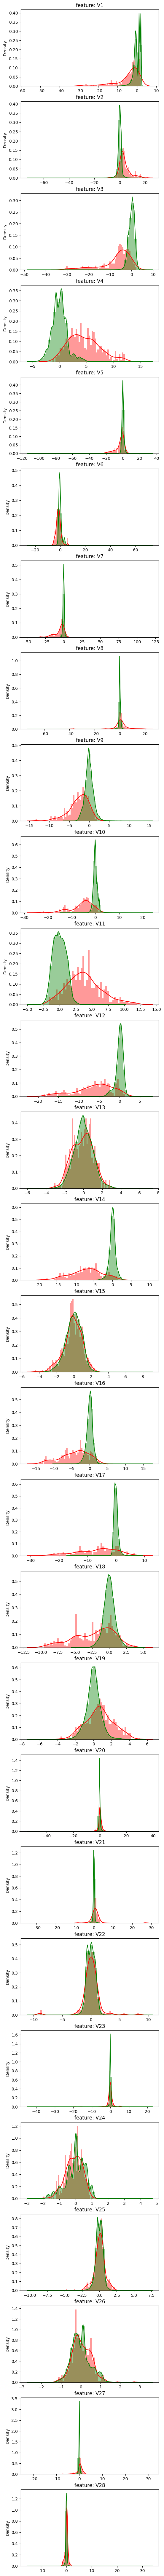

In [ ]:
import seaborn as sns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=50, color='r')
    sns.distplot(df[col][df.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()
#Features among V1 to V28 that show similar distributions for both genuine and fraudulent transactions
#will be removed to reduce the risk of overfitting and potentially improve model performance.
#'V28', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V20', 'V15', 'V13', 'V8' are considered to have similar distributions between the classes.

In [ ]:
def split_data(df, drop_list):
    df = df.drop(drop_list,axis=1)
    #test train split time
    from sklearn.model_selection import train_test_split
    y = df['Class'].values #target
    X = df.drop(['Class'],axis=1).values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                     stratify=y)

    print("train-set size: ", len(y_train),
      "\ntest-set size: ", len(y_test))
    print("fraud cases in test-set: ", sum(y_test))
    return X_train, X_test, y_train, y_test
print(df.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Time_Hr',
       'scaled_Amount'],
      dtype='object')


In [ ]:
def get_predictions(clf, X_train, y_train, X_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred))
    return y_pred, y_pred_prob
#This function trains the given classifier on the training data, returns the predicted labels and probabilities for the test data, and prints the confusion matrix for the training set.

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Case-1 : do not drop anything
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
a1=confusion_matrix(y_test,y_pred)
a2=recall_score(y_test,y_pred)
a3=precision_score(y_test,y_pred)
a4=f1_score(y_test,y_pred)
a5=accuracy_score(y_test,y_pred)
a6=roc_auc_score(y_test, y_pred_prob[:,1])
print('test-set confusion matrix:\n', a1)
print("recall score: ", a2)
print("precision score: ", a3)
print("f1 score: ", a4)
print("accuracy score: ", a5)
print("ROC AUC:", a6)

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[222598   4853]
 [    70    324]]
test-set confusion matrix:
 [[55562  1302]
 [   14    84]]
recall score:  0.8571428571428571
precision score:  0.06060606060606061
f1 score:  0.11320754716981132
accuracy score:  0.976896878620835
ROC AUC: 0.9551684541993499


In [ ]:
# Case-2 : drop # Case-NB-2 : drop 'V28', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V20', 'V15', 'V13', 'V8'
drop_list = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
b1=confusion_matrix(y_test,y_pred)
b2=recall_score(y_test,y_pred)
b3=precision_score(y_test,y_pred)
b4=f1_score(y_test,y_pred)
b5=accuracy_score(y_test,y_pred)
b6=roc_auc_score(y_test, y_pred_prob[:,1])
print('test-set confusion matrix:\n', b1)
print("recall score: ", b2)
print("precision score: ", b3)
print("f1 score: ", b4)
print("accuracy score: ", b5)
print("ROC AUC:", b6)

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223962   3489]
 [    59    335]]
test-set confusion matrix:
 [[55988   876]
 [   14    84]]
recall score:  0.8571428571428571
precision score:  0.0875
f1 score:  0.15879017013232513
accuracy score:  0.9843755486113549
ROC AUC: 0.9589393562011187


In [ ]:
# Case-3 : drop some of principle components + Time
drop_list = ['Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
c1=confusion_matrix(y_test,y_pred)
c2=recall_score(y_test,y_pred)
c3=precision_score(y_test,y_pred)
c4=f1_score(y_test,y_pred)
c5=accuracy_score(y_test,y_pred)
c6=roc_auc_score(y_test, y_pred_prob[:,1])
print('test-set confusion matrix:\n', c1)
print("recall score: ", c2)
print("precision score: ", c3)
print("f1 score: ", c4)
print("accuracy score: ", c5)
print("ROC AUC:", c6)

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223943   3508]
 [    60    334]]
test-set confusion matrix:
 [[55958   906]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08669354838709678
f1 score:  0.1577981651376147
accuracy score:  0.9838839928373302
ROC AUC: 0.9530141016733086


In [ ]:
# Case-4 : drop some of principle components + Time + 'scaled_Amount'
drop_list = ['scaled_Amount','Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
d1=confusion_matrix(y_test,y_pred)
d2=recall_score(y_test,y_pred)
d3=precision_score(y_test,y_pred)
d4=f1_score(y_test,y_pred)
d5=accuracy_score(y_test,y_pred)
d6=roc_auc_score(y_test, y_pred_prob[:,1])
print('test-set confusion matrix:\n', d1)
print("recall score: ", d2)
print("precision score: ", d3)
print("f1 score: ", d4)
print("accuracy score: ", d5)
print("ROC AUC:", d6)

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223905   3546]
 [    59    335]]
test-set confusion matrix:
 [[56010   854]
 [   13    85]]
recall score:  0.8673469387755102
precision score:  0.09052183173588925
f1 score:  0.16393442622950818
accuracy score:  0.9847793265685896
ROC AUC: 0.962952242658459


In [ ]:
scores = {
    "Case-1": {"recall": a2, "precision": a3,  "f1": a4, "accuracy": a5, "auc": a6},
    "Case-2": {"recall": b2, "precision": b3,  "f1": b4, "accuracy": b5, "auc": b6},
    "Case-3": {"recall": c2, "precision": c3,  "f1": c4, "accuracy": c5, "auc": c6},
    "Case-4": {"recall": d2, "precision": d3,  "f1": d4, "accuracy": d5, "auc": d6},
}

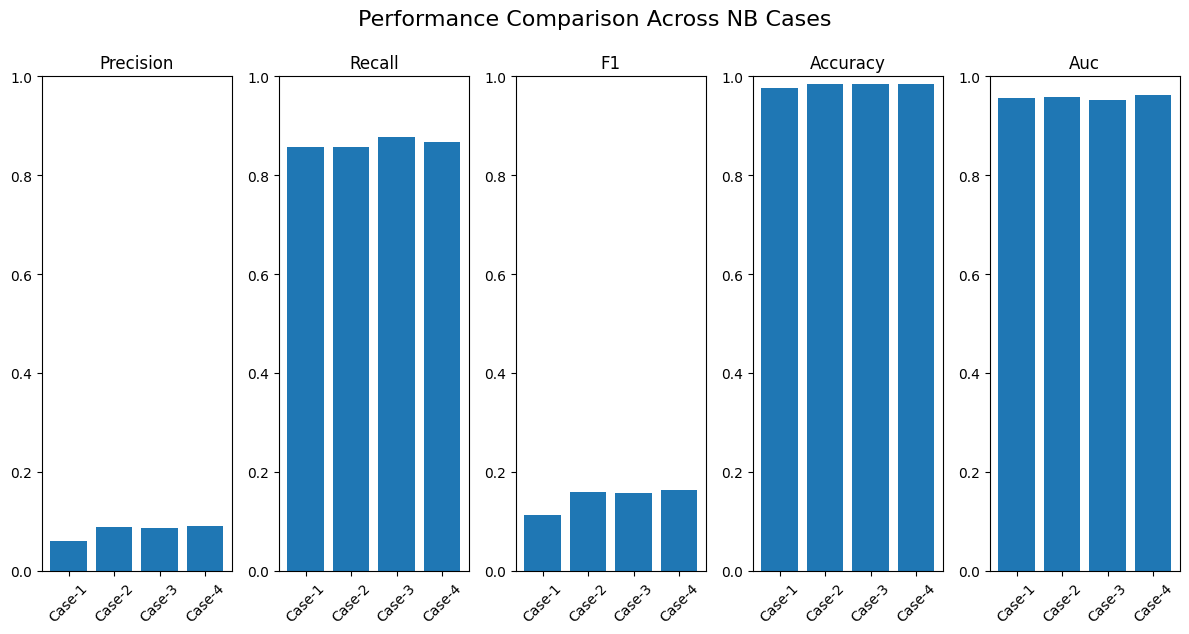

In [ ]:
import matplotlib.pyplot as plt
metrics = ["precision", "recall", "f1", "accuracy", "auc"]
cases = list(scores.keys())
values_by_metric = {metric: [scores[case][metric] for case in cases] for metric in metrics}


plt.figure(figsize=(12, 6))

for idx, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), idx + 1)
    plt.bar(cases, values_by_metric[metric])
    plt.title(metric.capitalize())
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("Performance Comparison Across NB Cases", fontsize=16, y=1.05)
plt.show()